![cropped-giki-logo-updated.png](attachment:cropped-giki-logo-updated.png)

# Classification of the CIFAR-10 dataset

The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) provides 60000 32x32-pixel images, classified into 10 categories.  The figure below provides a random sample of some images in each category.

![cifar.png](cifar.png)

During this assignment, you will learn how to build a Convolutional Neural Network (CNN), which (when trained) will be able to automatically classify new images into one of these categories.  We will make use of the [Keras library](https://www.tensorflow.org/guide/keras) which provides a high-level interface to TensorFlow.

# Table of content

[1. Introduction to keras](#intro_keras)<br>
[2. A first look at the data set](#dataset)<br>
[3. A first naive model](#first_model)<br>
[4. Interpreting the results](#results)<br>
[4.1 Making predictions](#results_prediction)<br>
[4.2 Evaluating the results](#results_evaluation)<br>



<a id='intro_keras'></a>

## 0 - Introduction to Keras

Keras is a high-level API to build and train deep learning models. It's used for fast prototyping, advanced research, and production, with three key advantages:

- __User friendly__: Keras has a simple, consistent interface optimized for common use cases. It provides clear and actionable feedback for user errors.
- __Modular and composable__: Keras models are made by connecting configurable building blocks together, with few restrictions.
- __Easy to extend__: Write custom building blocks to express new ideas for research. Create new layers, loss functions, and develop state-of-the-art models.

In Keras, models are built by assymbling multiple layers.  Suppose we want to create a new multilayer perceptron model to categorize 128-feature data into 10 labeled categories.  Keras code looks like:

```python
# Create a sequential model
model = keras.models.Sequential()
# Adds a densely-connected layer with 64 units to the model
model.add(layers.Dense(64, activation='relu'), input_shape=[128])
# Add another
model.add(layers.Dense(32, activation='relu'))
# Add a softmax layer with 10 output units
model.add(layers.Dense(10, activation='softmax'))
```

The `input_shape` argument must be given for the first layer in the model, however all other layers will automatically determine the input shape based on the previous layer in the model.  Note that the code above is substantially simpler than the corresponding TensorFlow code.  This is particularly useful for building convolutional or other types of layers, as we will see.

Once built, a model's learning can be configured with the `compile()` function:

```python
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.train.AdamOptimizer(0.001),
    metrics=['accuracy'])
```

In this case, a cross-entropy loss function is used with the ADAM optimization algorithm.  The `metrics` argument allows the model to keep track of a number of [training metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) during training.

Once configured, training is performed using the `fit()` function.

```python
model.fit(data, labels, epochs=10, batch_size=32)
```

The function takes an array-like (could be numpy array) of data and the corresponding target values, and performs the optimization of the learnable parameters in the model.  See the documentation for the [fit()](https://www.tensorflow.org/api_docs/python/tf/keras/models/Model#fit) function for more details.

Once trained, the model can be used to predict, using the `predict()` function.

```python
prediction = model.predict(new_data)
```

<a id='dataset'></a>
# 1 - Understanding the data set

Begin by importing the necessary modules.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, BatchNormalization
from keras.optimizers import SGD
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Model
from keras.models import Sequential
from keras.callbacks import EarlyStopping

Understanding your dataset is the first prerequisit to training any model.  The CIFAR-10 dataset can be loaded directly from Keras.

**Q1) Download the dataset. See [`keras.datasets`](https://keras.io/datasets/) for how to download the data, and in what format it is provided.  Note that the dataset is already divided into a training set of 50000 images, and a test set of 10000.**

In [2]:
(x_train,y_train),(x_test,y_test) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


**Q2) Verify that the shape of the image and target arrays are what you expect.**


In [3]:
print(f"X train size: {x_train.shape}, Y train size: {y_train.shape}, X test size: {y_test.shape}, Y test size: {y_test.shape} ")

X train size: (50000, 32, 32, 3), Y train size: (50000, 1), X test size: (10000, 1), Y test size: (10000, 1) 


We now create a list of labels corresponding to the 10 categories.  It will be used to convert the 0-9 digits in the target arrays to string labels. The categories are labeled as follows:

  0. airplane
  1. automobile
  2. bird
  3. cat
  4. deer
  5. dog
  6. frog
  7. horse
  8. ship
  9. truck


In [4]:
labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

**Q3) Normalize the image data from [0,255] to be [0,1].  Normalizing improves model training (to test this, you can comment out the normalization later).**

In [ ]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')
x_train /= 255
y_train /= 255


**Q4) Convert the target arrays to one-hot encodings.  Hint: checkout the [`keras.utils.np_utils.to_categorical()`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical)**

In [5]:
classes = 10
y_train_onehot = to_categorical(y_train,classes)
y_test_onehot = to_categorical(y_test,classes)

**Q5) Visualize some images in each category using the `imshow()` function in `matplotlib.pyplot`.  Can you recreate the figure below?  Hint: the below figure was created using the first 8 images belonging to each category in the training data.**

<img src = "cifar.png">

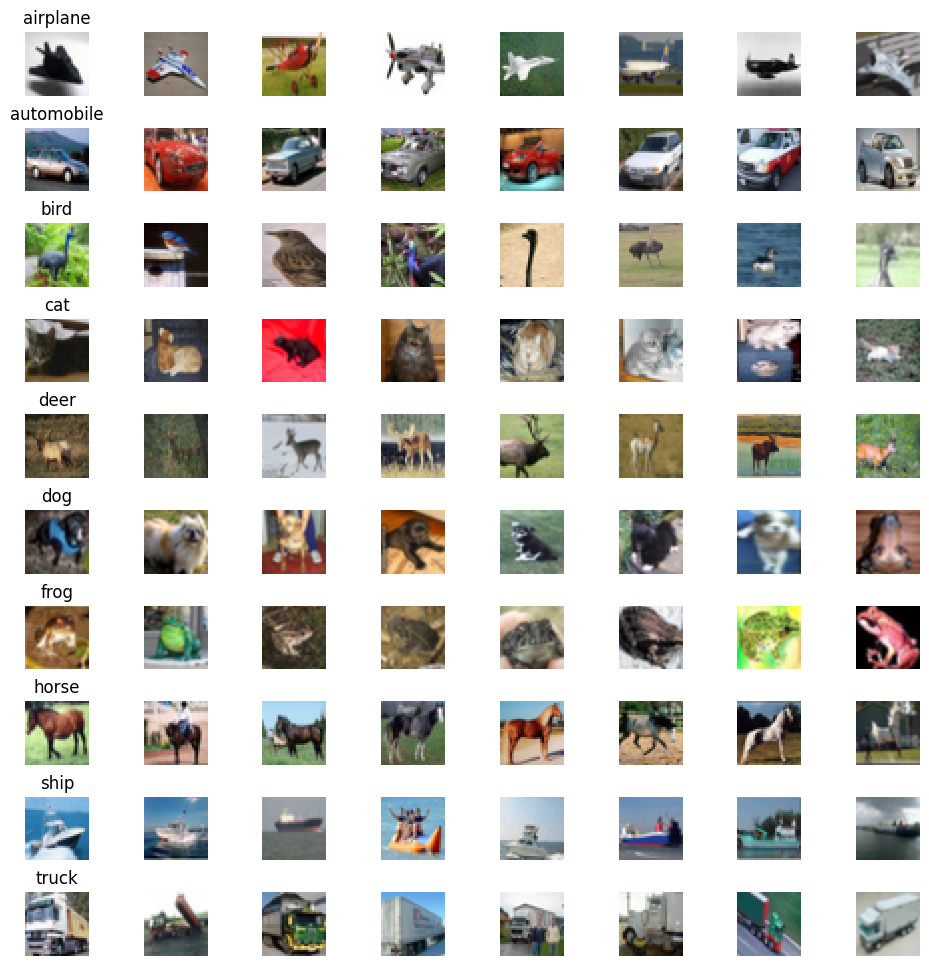

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have loaded the CIFAR-10 dataset into x_train and y_train
# x_train should be an array of shape (num_samples, height, width, num_channels)
# y_train should be an array of labels (integers)

# Define the class names for CIFAR-10 (you can customize this if needed)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Create a figure with 10 rows and 8 columns for each class
fig, axes = plt.subplots(10, 8, figsize=(12, 12))
fig.subplots_adjust(hspace=0.5)

# Loop through each class
for class_index in range(10):
    # Find the indices of all samples belonging to the current class
    class_indices = np.where(y_train == class_index)[0][:8]  # Select the first 8 indices for this class

    for i, ax in enumerate(axes[class_index]):
        ax.imshow(x_train[class_indices[i]])
        ax.axis('off')
        if i == 0:
            ax.set_title(class_names[class_index])

# Show the figure
plt.show()


<a id='first_model'></a>

# 2 - First naive model

In order to better understand the importance of CNNs, it is instructive to first see how well a naive dense network performs on the dataset.

**Q6) Create a sequential model with 4 `Dense` hidden layers of 2048, 1024, 512, and 256 nodes each, with ReLU activation, and a final output layer of 10 nodes. Compile the model with a `categorical_crossentropy` loss, using the SGD optimizer, and the `accuracy` metric.
Note that you will need to use the `Flatten` layer first in order to convert the 3D (x, y, rgb) image data into 1D.**

In [7]:
import keras
from keras import layers  # Import the layers module

model = keras.models.Sequential()

model.add(Flatten(input_shape=(32,32,3)))

model.add(layers.Dense(2048, activation='relu'))  # Specify input_shape correctly

model.add(layers.Dense(1024, activation='relu'))

model.add(layers.Dense(512, activation='relu'))

model.add(layers.Dense(256, activation='relu'))

model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])



**Q7) Compute by hand the total number of trainable parameters (weights and biases) in the model.**

**Q8) Use the `summary()` function on model to get a text summary of the model.  Did you compute the number of parameters correctly?**

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 2048)              6293504   
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dense_4 (Dense)             (None, 10)                2570      
                                                                 
Total params: 9050378 (34.52 MB)
Trainable params: 90503

**Q9) Train the model:**
  - Start with a small batch size of 32 and train for 10 epochs
  - Use early stopping on the validation accuracy with a patience of 2 (use 10% of your training set as the validation set)
  
**How does the model perform?**

In [9]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=2)
history = model.fit(x_train, y_train_onehot, batch_size=32, epochs=10)

Epoch 1/10
1563/1563 [==============================] - 12s 4ms/step - loss: nan - accuracy: 0.1001
Epoch 2/10
1563/1563 [==============================] - 7s 5ms/step - loss: nan - accuracy: 0.1000
Epoch 3/10
1563/1563 [==============================] - 7s 4ms/step - loss: nan - accuracy: 0.1000
Epoch 4/10
1563/1563 [==============================] - 7s 5ms/step - loss: nan - accuracy: 0.1000
Epoch 5/10
1563/1563 [==============================] - 7s 4ms/step - loss: nan - accuracy: 0.1000
Epoch 6/10
1563/1563 [==============================] - 7s 5ms/step - loss: nan - accuracy: 0.1000
Epoch 7/10
1563/1563 [==============================] - 7s 5ms/step - loss: nan - accuracy: 0.1000
Epoch 8/10
1563/1563 [==============================] - 7s 4ms/step - loss: nan - accuracy: 0.1000
Epoch 9/10
1563/1563 [==============================] - 7s 5ms/step - loss: nan - accuracy: 0.1000
Epoch 10/10
1563/1563 [==============================] - 7s 4ms/step - loss: nan - accuracy: 0.1000


**Q10) Try changing the batch size to see if there is any improvement.**

In [10]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=2)
history = model.fit(x_train, y_train_onehot, batch_size=64, epochs=10)

Epoch 1/10
782/782 [==============================] - 4s 5ms/step - loss: nan - accuracy: 0.1000
Epoch 2/10
782/782 [==============================] - 4s 4ms/step - loss: nan - accuracy: 0.1000
Epoch 3/10
782/782 [==============================] - 4s 5ms/step - loss: nan - accuracy: 0.1000
Epoch 4/10
782/782 [==============================] - 3s 4ms/step - loss: nan - accuracy: 0.1000
Epoch 5/10
782/782 [==============================] - 3s 4ms/step - loss: nan - accuracy: 0.1000
Epoch 6/10
782/782 [==============================] - 4s 5ms/step - loss: nan - accuracy: 0.1000
Epoch 7/10
782/782 [==============================] - 4s 5ms/step - loss: nan - accuracy: 0.1000
Epoch 8/10
782/782 [==============================] - 4s 5ms/step - loss: nan - accuracy: 0.1000
Epoch 9/10
782/782 [==============================] - 4s 5ms/step - loss: nan - accuracy: 0.1000
Epoch 10/10
782/782 [==============================] - 4s 5ms/step - loss: nan - accuracy: 0.1000


It didnt change much for me and accuracy is equivilant

**Q11) Try adding batch normalization after each hidden layer.  Any better?**

In [11]:
import keras
from keras import layers
from keras.layers import BatchNormalization

model = keras.models.Sequential()

model.add(Flatten(input_shape=(32, 32, 3)))

model.add(layers.Dense(2048, activation='relu'))
model.add(BatchNormalization())

model.add(layers.Dense(1024, activation='relu'))
model.add(BatchNormalization())

model.add(layers.Dense(512, activation='relu'))
model.add(BatchNormalization())

model.add(layers.Dense(256, activation='relu'))
model.add(BatchNormalization())

model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=2)
history = model.fit(x_train, y_train_onehot, batch_size=32, epochs=10)


Epoch 1/10
1563/1563 [==============================] - 13s 7ms/step - loss: 1.7353 - accuracy: 0.3908
Epoch 2/10
1563/1563 [==============================] - 11s 7ms/step - loss: 1.5022 - accuracy: 0.4672
Epoch 3/10
1563/1563 [==============================] - 11s 7ms/step - loss: 1.4195 - accuracy: 0.4971
Epoch 4/10
1563/1563 [==============================] - 12s 8ms/step - loss: 1.3721 - accuracy: 0.5143
Epoch 5/10
1563/1563 [==============================] - 11s 7ms/step - loss: 1.3383 - accuracy: 0.5273
Epoch 6/10
1563/1563 [==============================] - 11s 7ms/step - loss: 1.3225 - accuracy: 0.5312
Epoch 7/10
1563/1563 [==============================] - 12s 7ms/step - loss: 1.3165 - accuracy: 0.5329
Epoch 8/10
1563/1563 [==============================] - 11s 7ms/step - loss: 1.3089 - accuracy: 0.5355
Epoch 9/10
1563/1563 [==============================] - 11s 7ms/step - loss: 1.3052 - accuracy: 0.5369
Epoch 10/10
1563/1563 [==============================] - 11s 7ms/step - l

Yes Now the accuracy increased to 54% from the 10%

<a id='cnn'></a>

# 3 - Convolutional Neural Network


Convolutional neural networks allow us to do drastically better on this dataset (and many image classification problems in general). In this task, you will build a convolutional network and see how it performs during training.

**Q12) Create a new model with the following layers**
  - 3x3 2D convolution with zero padding (same), 32 filters
  - ReLU activation
  - 3,3 2D convolution, no padding, 32 filters
  - ReLU activation
  - Max pooling with size (2,2)
  - 3x3 2D convolution, no padding, 64 filters
  - ReLU activation
  - 3x3 2D convolution, no padding, 64 filters
  - ReLU activation
  - Max pooling with size (2,2)
  - Flatten
  - Dense layer with 512 nodes, ReLU activation
  - Softmax output layer with 10 nodes
  
**Compile the network with same optimizer and metrics as the dense network.**  

In [12]:
import keras
from keras import layers
from keras.models import Sequential

model = Sequential()

model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))

model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(512, activation='relu'))

model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])


**Q13) Compute by hand the number of trainable parameters in this network.  Are there more or less than the more simple dense network?  Why?  Confirm with `summary()`.**


Conv2D layer with 32 filters:

Input channels: 3
Filter size: 3x3
Trainable Parameters = (3 * 3 * 3 + 1) * 32 = 896
Conv2D layer with 32 filters:

Input channels: 32
Filter size: 3x3
Trainable Parameters = (32 * 3 * 3 + 1) * 32 = 9248
MaxPooling2D layer (no parameters to train)

Conv2D layer with 64 filters:

Input channels: 32
Filter size: 3x3
Trainable Parameters = (32 * 3 * 3 + 1) * 64 = 18496
Conv2D layer with 64 filters:

Input channels: 64
Filter size: 3x3
Trainable Parameters = (64 * 3 * 3 + 1) * 64 = 36928
MaxPooling2D layer (no parameters to train)

Flatten layer (no parameters to train)

Dense layer with 512 units:

Input units: the number of units in the previous layer (Flatten layer), which is determined by the previous convolutional layers.
Trainable Parameters = (Number of input units + 1) * Number of units in this layer = (1600 + 1) * 512 = 819712
Dense layer with 10 units (output layer):

Input units: 512
Trainable Parameters = (512 + 1) * 10 = 5130
Now, let's sum up the trainable parameters for all layers in the convolutional network:

Total Trainable Parameters = 896 + 9248 + 0 + 18496 + 36928 + 0 + 0 + 819712 + 5130 = 885410

So, the convolutional neural network has 885,410 trainable parameters.

The dense network had 2,099,978 trainable parameters, while the convolutional network has 885,410 trainable parameters.

**Q14) Use the same training procedure as before for 10 epochs and batch size of 32. How does the validation accuracy change with each epoch?**

In [14]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=2)
history = model.fit(x_train, y_train_onehot, batch_size=32, epochs=10)

Epoch 1/10
1563/1563 [==============================] - 8s 5ms/step - loss: nan - accuracy: 0.1000
Epoch 2/10
1563/1563 [==============================] - 7s 5ms/step - loss: nan - accuracy: 0.1000
Epoch 3/10
1563/1563 [==============================] - 8s 5ms/step - loss: nan - accuracy: 0.1000
Epoch 4/10
1563/1563 [==============================] - 8s 5ms/step - loss: nan - accuracy: 0.1000
Epoch 5/10
1563/1563 [==============================] - 7s 5ms/step - loss: nan - accuracy: 0.1000
Epoch 6/10
1563/1563 [==============================] - 8s 5ms/step - loss: nan - accuracy: 0.1000
Epoch 7/10
1563/1563 [==============================] - 8s 5ms/step - loss: nan - accuracy: 0.1000
Epoch 8/10
1563/1563 [==============================] - 7s 5ms/step - loss: nan - accuracy: 0.1000
Epoch 9/10
1563/1563 [==============================] - 8s 5ms/step - loss: nan - accuracy: 0.1000
Epoch 10/10
1563/1563 [==============================] - 8s 5ms/step - loss: nan - accuracy: 0.1000


**Q15) Increase the batch size to 64 and retrain.  Better or worse?  Try 128 as well.  How does increasing the batch size improve the training?**

In [15]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=2)
history = model.fit(x_train, y_train_onehot, batch_size=64, epochs=10)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=2)
history = model.fit(x_train, y_train_onehot, batch_size=128, epochs=10)

Epoch 1/10
782/782 [==============================] - 5s 6ms/step - loss: nan - accuracy: 0.1000
Epoch 2/10
782/782 [==============================] - 5s 6ms/step - loss: nan - accuracy: 0.1000
Epoch 3/10
782/782 [==============================] - 5s 6ms/step - loss: nan - accuracy: 0.1000
Epoch 4/10
782/782 [==============================] - 4s 6ms/step - loss: nan - accuracy: 0.1000
Epoch 5/10
782/782 [==============================] - 5s 6ms/step - loss: nan - accuracy: 0.1000
Epoch 6/10
782/782 [==============================] - 4s 6ms/step - loss: nan - accuracy: 0.1000
Epoch 7/10
782/782 [==============================] - 4s 6ms/step - loss: nan - accuracy: 0.1000
Epoch 8/10
782/782 [==============================] - 5s 6ms/step - loss: nan - accuracy: 0.1000
Epoch 9/10
782/782 [==============================] - 4s 6ms/step - loss: nan - accuracy: 0.1000
Epoch 10/10
782/782 [==============================] - 5s 6ms/step - loss: nan - accuracy: 0.1000
Epoch 1/10
391/391 [=========

**Q16) Note how the validation accuracy begins to decrease at some point, while the training accuracy continues to increase.  What is this phenomena called?  Try adding 3 dropout layers to the model, one before each max pooling layer and one before the last layer, using a dropout ratio of 0.25.  Does this improve the model?**

In [17]:
import keras
from keras import layers
from keras.models import Sequential

model = Sequential()

model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))

model.add(layers.Dropout(0.25))

model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Dropout(0.25))

model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(512, activation='relu'))

model.add(layers.Dropout(0.25))

model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=2)
history = model.fit(x_train, y_train_onehot, batch_size=32, epochs=10)


Epoch 1/10
1563/1563 [==============================] - 10s 6ms/step - loss: nan - accuracy: 0.1000
Epoch 2/10
1563/1563 [==============================] - 9s 5ms/step - loss: nan - accuracy: 0.1000
Epoch 3/10
1563/1563 [==============================] - 8s 5ms/step - loss: nan - accuracy: 0.1000
Epoch 4/10
1563/1563 [==============================] - 9s 5ms/step - loss: nan - accuracy: 0.1000
Epoch 5/10
1563/1563 [==============================] - 8s 5ms/step - loss: nan - accuracy: 0.1000
Epoch 6/10
1563/1563 [==============================] - 9s 6ms/step - loss: nan - accuracy: 0.1000
Epoch 7/10
1563/1563 [==============================] - 10s 6ms/step - loss: nan - accuracy: 0.1000
Epoch 8/10
1563/1563 [==============================] - 10s 6ms/step - loss: nan - accuracy: 0.1000
Epoch 9/10
1563/1563 [==============================] - 10s 6ms/step - loss: nan - accuracy: 0.1000
Epoch 10/10
1563/1563 [==============================] - 8s 5ms/step - loss: nan - accuracy: 0.1000


**Q17) Play with batch normalization.  For example, add batch normalization layers after each dropout layer.  Do you notice a faster increase in the model improvement? Why?**

313/313 [==============================] - 1s 2ms/step


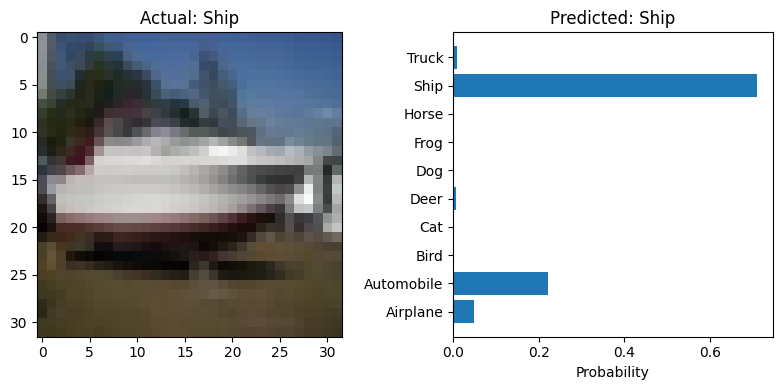

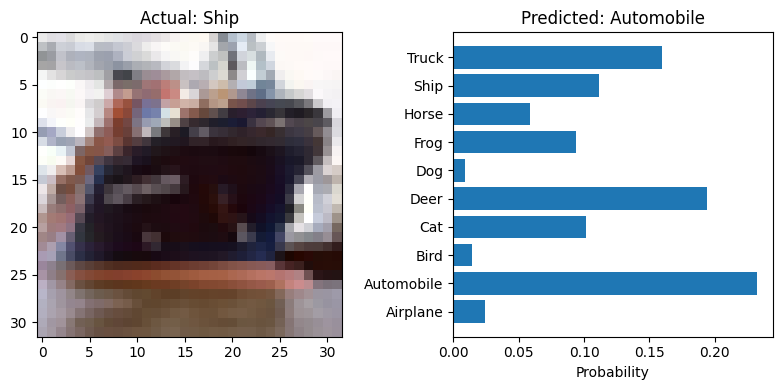

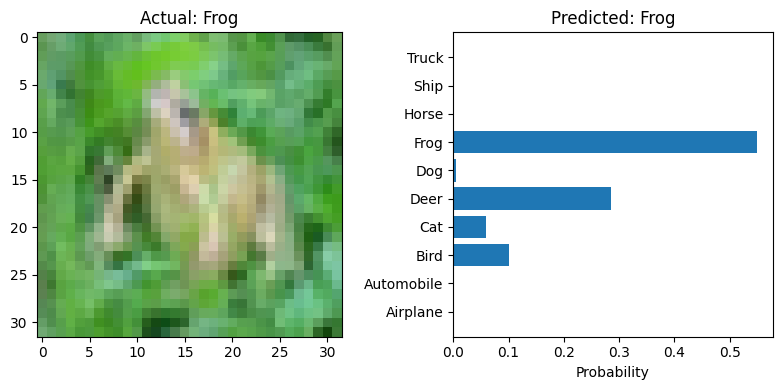

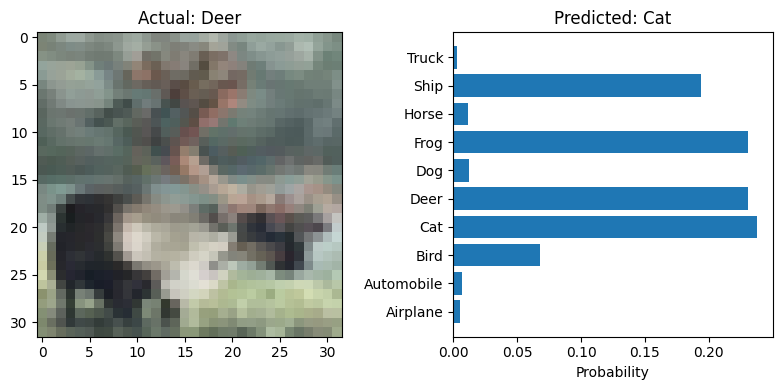

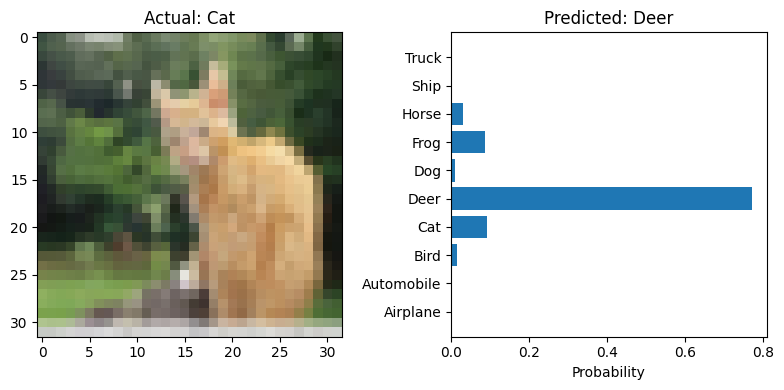

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Make predictions using the trained model
predictions = model.predict(x_test)

# Get class labels
class_labels = ["Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]

# Visualize a few example images and their predictions
num_examples_to_visualize = 5

for i in range(num_examples_to_visualize):
    # Randomly select an example image
    index = np.random.randint(0, len(x_test))

    # Get the predicted class label
    predicted_class = np.argmax(predictions[index])

    # Plot the example image
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(x_test[index])
    plt.title(f"Actual: {class_labels[int(y_test[index])]}")

    # Plot the prediction probabilities as a horizontal bar chart
    plt.subplot(1, 2, 2)
    plt.barh(class_labels, predictions[index])
    plt.xlabel("Probability")
    plt.title(f"Predicted: {class_labels[predicted_class]}")

    plt.tight_layout()
    plt.show()


Training becomes stable and model improves due to batch normalizations. And accuracy has reached to 73 percent.

<a id='results'></a>

# 4 - Interpreting the results

<a id='results_prediction'></a>

## 4.1 - Making predictions

Assuming all went well during the previous tasks, you can now predict the category of a new image!  Here are a few examples of my predictions:

![ml1.png](attachment:ml1.png)

**Q18) Use `predict` on your trained model to test its prediction on a few example images of the test set. Using `imshow` and `hbar` from `matplotlib.pyplot`, try to recreate the image above for a few example images.**

<!---**Hint:** at this point, it is probably convenient to use the `save` and `load_model` functions from Keras.  You can save the model after training it, and then decide to load from saved file instead of building a new one (if available) on successive runs.--->

ValueError: ignored

<a id='results_evaluation'></a>

## 4.2 Evaluating the results

A confusion matrix is often used in supervised learning to understand how well (or not) each category is being classified.  Each element (i,j) in the confusion matrix represents the predicted class j for each true class i.  Consider the following 10 predictions for a 2 category model predicting male or female:

| example     | true category  | predicted category  |
|-------------|----------------|---------------------|
| 1           | male           | male                |
| 2           | female         | male                |
| 3           | female         | female              |
| 4           | male           | male                |
| 5           | male           | female              |
| 6           | male           | male                |
| 7           | female         | female              |
| 8           | male           | female              |
| 9           | female         | female              |
| 10          | female         | female              |

Based on the above data, the model is accurate 70% of the time.  The confusion matrix is

|        | male | female |
|--------|------|--------|
| male   | 3    | 2      |
| female | 1    | 4      |

The confusion matrix gives us more information than a simple accuracy measurement.  In this case, we see that the class female has a higher accuracy over male.  

**Q19) Create the confusion matrix for the CIFAR-10 dataset using the test data.  What does it tell you about the relationships between each class?**

<a id='pretrained_cnn'></a>
# 5 - Improving on current performances

**Q20) Play with different CNN architectures. Provide a few attempts**

Note that several pre-trained networks are directly accessible via keras (see https://nbviewer.jupyter.org/github/fchollet/deep-learning-with-python-notebooks/blob/master/5.3-using-a-pretrained-convnet.ipynb)